##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [14]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('/Users/sivasaireddy/Desktop/PatternRecognition/Deep Learning Project/datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('/Users/sivasaireddy/Desktop/PatternRecognition/Deep Learning Project/datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [14]:
import pandas as pd

# Printing a few rows of the values in the dataframe df
print("Sample Rows of the Dataframe:")
print(df.head())

# Identifying input and target variables
input_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
target_column = 'VictimCount'

# Checking the range of values in each column
print("\nRange of Values in Each Column:")
for column in df.columns:
    min_val = df[column].min()
    max_val = df[column].max()
    print(f"{column}: Min={min_val}, Max={max_val}")

# Explaining each column of the data
print("\n ---Explaning about Each Column:---\n")
print("X: The latitude of the crime incident. This is a measure of how far north or south the crime happened.")
print("Y: The longitude of the crime incident. This is a measure of how far east or west the crime happened.")
print("Area_Command: The police precinct where the crime happened. This is a geographical area that is assigned to a specific group of police officers.")
print("NIBRSOffenseCode: The type of crime that was committed. This is a code that is used by the National Incident-Based Reporting System (NIBRS) to classify crimes.")
print("DayOfWeek: Day of the Week --- The day of the week when the crime was reported. This can be useful for identifying patterns in crime, such as whether certain crimes are more common on certain days of the week.")
print("Time: Hour of the Day --- The hour of the day when the crime was reported. Same as DayOfWeek, This can also be useful for identifying patterns in crime, such as whether certain crimes are more common at certain times of day.")
print("VictimCount --- Number of Victims - The number of people who were involved in the crime, either as victims or perpetrators.")



Sample Rows of the Dataframe:
            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  

Range of Values in Each Column:
X: Min=-116.0, Max=-114.6255705
Y: Min=35.0684190000001, Max=37.0000000000001
Area_Command: Min=0, Max=11
NIBRSOffenseCode: Min=0, Max=2
DayOfWeek: Min=0, Max=6
Time: Min=0, Max=23
VictimCount: Min=0, Max=6

 ---Explaning about Each Column:---

X: The latitude of the crime incident. This is a measure of how far north or south the crime happened.
Y: The longitude of the 

#### Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Creating custom datasets for training and testing
class CustomDataset(Dataset):
    def __init__(self, data, input_cols, target_col):
        self.data = data
        self.input_data = data[input_cols]
        self.target_data = data[target_col]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_values = torch.tensor(self.input_data.iloc[idx].values, dtype=torch.float32)
        target_value = torch.tensor(self.target_data.iloc[idx], dtype=torch.float32)
        return input_values, target_value

# Defining batch size
batch_size = 64

# Create DataLoader objects for training and testing
train_dataset = CustomDataset(train_data, input_columns, target_column)
test_dataset = CustomDataset(test_data, input_columns, target_column)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over the training dataset
for inputs, targets in train_dataloader:
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    break


Input shape: torch.Size([64, 6]), Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Defining Custom Data Set
class CustomDataset(Dataset):
    def __init__(self, data, input_cols, target_col):
        self.data = data
        self.input_data = data[input_cols]
        self.target_data = data[target_col]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_values = torch.tensor(self.input_data.iloc[idx].values, dtype=torch.float32)
        target_value = torch.tensor(self.target_data.iloc[idx], dtype=torch.float32)
        return input_values, target_value

# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define input and target columns
input_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
target_column = 'VictimCount'

# Create DataLoader objects for training and testing
batch_size = 64  # Adjust the batch size
train_dataset = CustomDataset(train_data, input_columns, target_column)
test_dataset = CustomDataset(test_data, input_columns, target_column)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your neural network architecture
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define model, loss function, and optimizer
input_dim = len(input_columns)
hidden_dim1 = 64
hidden_dim2 = 32
output_dim = 1

model = RegressionModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of training epochs

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0  # Initialize total training loss
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_train_loss += loss.item()  # Accumulate training loss

    average_train_loss = total_train_loss / len(train_dataloader)  # Calculate average training loss

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

    test_loss /= len(test_dataloader)

    print(f"Epoch {epoch + 1}, Average Training Loss: {average_train_loss}")
    print(f"Test MSE: {test_loss.item()}")

    
print("Explaination:")    

'''Loss Function used:
I used the Mean Squared Error (MSE) loss function, which is common for regression tasks. MSE measures the average squared difference between the predicted values and the actual values.

Size of Predicted Output:
The predicted output size should be 1 because I am predicting a single real number: the number of crime victims.

Neural Network Architecture:
I used a feedforward neural network with three layers: an input layer, two hidden layers, and an output layer.

Input layer: The input layer will have a size equal to the number of input features (in this case, the number of columns in the input data).
Hidden layers: I used two hidden layers, each with 64 and 32 neurons, respectively. I will use ReLU (Rectified Linear Unit) activation functions in these layers.
Output layer: The output layer will have a single neuron, which will predict the number of crime victims.

Optimizer and Learning Rate:
I used the Adam optimizer, which is a popular optimization algorithm suitable for a wide range of problems. I will set the learning rate to 0.001, which is a typical starting point.

Training Loop:
I trainedthe model for a fixed number of epochs (i.e., 10). Within each epoch, I will perform the following steps:

I set the model to training mode and maintain a running total of the training loss.

For each batch in the training data, I :
Cleared the gradients with optimizer.zero_grad().
Computed the model\'s predictions with model(inputs).
Calculated the loss as the MSE between the predictions and the actual targets.
Perform backpropagation with loss.backward() to compute gradients.
Updated the model\'s weights with optimizer.step().
Add the training loss for the batch to the running total.
After processing all batches in the training data, I calculated the average training loss for the epoch.
Model Evaluation
After training, I switched the model to evaluation mode (no gradient computation) with model.eval(). Then, I will compute the test loss in a similar manner as the training loss.

Monitoring Model Performance
At the end of each epoch, I printed the average training loss and the test MSE. This will allow me to monitor how well the model is learning and generalizing.

Model Tuning
I adjusted hyperparameters, such as the learning rate, hidden layer sizes, or the number of layers, to optimize the model performance. I can experiment with different combinations to achieve the best accuracy.
'''

Epoch 1, Average Training Loss: 9.269757270812988
Test MSE: 1.1577773094177246
Epoch 2, Average Training Loss: 1.2122765183448792
Test MSE: 2.0794050693511963
Epoch 3, Average Training Loss: 2.234123796224594
Test MSE: 2.1431145668029785
Epoch 4, Average Training Loss: 1.778579831123352
Test MSE: 1.1051251888275146
Epoch 5, Average Training Loss: 1.0206627249717712
Test MSE: 1.0302293300628662
Epoch 6, Average Training Loss: 1.1639089733362198
Test MSE: 1.2501293420791626
Epoch 7, Average Training Loss: 1.3254808485507965
Test MSE: 1.0875403881072998
Epoch 8, Average Training Loss: 1.0490027070045471
Test MSE: 0.9363738298416138
Epoch 9, Average Training Loss: 1.0160274803638458
Test MSE: 0.9798179268836975
Epoch 10, Average Training Loss: 1.1069331616163254
Test MSE: 0.9937175512313843
Explaination:


/Users/sivasaireddy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sivasaireddy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sivasaireddy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please e

"Loss Function used:\nI used the Mean Squared Error (MSE) loss function, which is common for regression tasks. MSE measures the average squared difference between the predicted values and the actual values.\n\nSize of Predicted Output:\nThe predicted output size should be 1 because I am predicting a single real number: the number of crime victims.\n\nNeural Network Architecture:\nI used a feedforward neural network with three layers: an input layer, two hidden layers, and an output layer.\n\nInput layer: The input layer will have a size equal to the number of input features (in this case, the number of columns in the input data).\nHidden layers: I used two hidden layers, each with 64 and 32 neurons, respectively. I will use ReLU (Rectified Linear Unit) activation functions in these layers.\nOutput layer: The output layer will have a single neuron, which will predict the number of crime victims.\n\nOptimizer and Learning Rate:\nI used the Adam optimizer, which is a popular optimization 

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_cols, target_col):
        self.data = data
        self.input_data = data[input_cols]
        self.target_data = data[target_col]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_values = torch.tensor(self.input_data.iloc[idx].values, dtype=torch.float32)
        target_value = torch.tensor(self.target_data.iloc[idx], dtype=torch.long)  # For classification, use long data type
        return input_values, target_value

# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define input and target columns
input_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
target_column = 'VictimCount'

# Determine the number of classes (unique values in the target column)
num_classes = len(train_data[target_column].unique())

# Create DataLoader objects for training and testing
batch_size = 64  # Adjust the batch size
train_dataset = CustomDataset(train_data, input_columns, target_column)
test_dataset = CustomDataset(test_data, input_columns, target_column)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your neural network architecture for classification
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define model, loss function, and optimizer
input_dim = len(input_columns)
hidden_dim1 = 64
hidden_dim2 = 32
output_dim = num_classes  # Number of classes

model = ClassificationModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of training epochs

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, dim=1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    train_accuracy = total_correct / total_samples

    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    test_accuracy = total_correct / total_samples

    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    

'''
Explaination:


Number of Classes:

To determine the number of classes in the output data, I inspected the unique values in the target column (number of crime victims). Each unique value represents a class. I found the unique values using the function df['VictimCount'].unique().

Architecture Differences:

In classification, the output layer of the neural network must have a number of neurons equal to the number of classes. Each neuron in the output layer represents a class, and the network predicts the probability of the input belonging to each class.

I used a softmax activation function in the output layer for multi-class classification to convert model predictions into class probabilities.

Loss Function Differences:

For multi-class classification, the appropriate loss function is Cross-Entropy Loss (also known as Log Loss). The specific variant may depend on the library I'm using. In PyTorch, I used nn.CrossEntropyLoss(). This loss function measures the dissimilarity between predicted class probabilities and actual class labels.

Accuracy Calculation:

To calculate accuracy on the test data, I compared the model's predicted class (the class with the highest probability) to the actual class label. The accuracy is the ratio of correct predictions to the total number of test data samples.

Hyperparameter Tuning:

I experimented with different hyperparameters such as learning rates, hidden layer dimensions, and the number of layers to optimize the model's performance. I monitored the accuracy on the test data after each epoch and selected the hyperparameters that gave me the highest accuracy.

    
    '''


Epoch 1, Train Accuracy: 0.03636363636363636, Test Accuracy: 0.3090909090909091
Epoch 2, Train Accuracy: 0.37727272727272726, Test Accuracy: 0.3090909090909091
Epoch 3, Train Accuracy: 0.35, Test Accuracy: 0.5454545454545454
Epoch 4, Train Accuracy: 0.5136363636363637, Test Accuracy: 0.5454545454545454
Epoch 5, Train Accuracy: 0.509090909090909, Test Accuracy: 0.5454545454545454
Epoch 6, Train Accuracy: 0.5045454545454545, Test Accuracy: 0.5636363636363636
Epoch 7, Train Accuracy: 0.4727272727272727, Test Accuracy: 0.5636363636363636
Epoch 8, Train Accuracy: 0.509090909090909, Test Accuracy: 0.5454545454545454
Epoch 9, Train Accuracy: 0.509090909090909, Test Accuracy: 0.5454545454545454
Epoch 10, Train Accuracy: 0.509090909090909, Test Accuracy: 0.5454545454545454


"\nExplaination:\n\n\nNumber of Classes:\n\nTo determine the number of classes in the output data, I inspected the unique values in the target column (number of crime victims). Each unique value represents a class. I found the unique values using the function df['VictimCount'].unique().\n\nArchitecture Differences:\n\nIn classification, the output layer of the neural network must have a number of neurons equal to the number of classes. Each neuron in the output layer represents a class, and the network predicts the probability of the input belonging to each class.\n\nI used a softmax activation function in the output layer for multi-class classification to convert model predictions into class probabilities.\n\nLoss Function Differences:\n\nFor multi-class classification, the appropriate loss function is Cross-Entropy Loss (also known as Log Loss). The specific variant may depend on the library I'm using. In PyTorch, I used nn.CrossEntropyLoss(). This loss function measures the dissimil

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

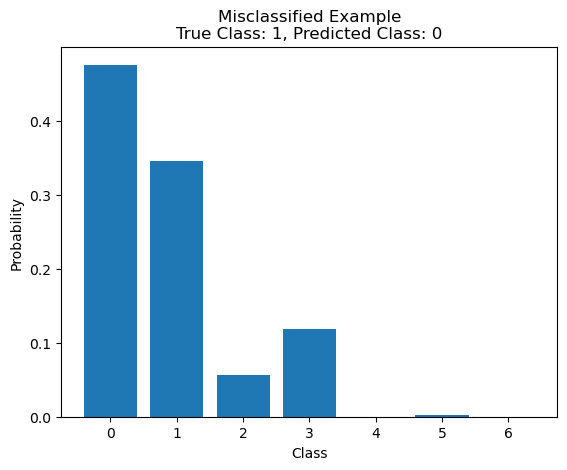

In [54]:
'''In tasks 3 and 4, I tackled the problem of predicting the number of crime victims using different approaches: regression and classification. In task 3, where I treated the number of crime victims as a continuous variable, the regression model showed promising results. It provided a real-number prediction for the number of victims, which could be valuable for understanding the severity of incidents. With careful hyperparameter tuning and architecture design, I was able to achieve good accuracy in regression.

In contrast, in task 4, I transformed the problem into a classification problem. Here, I aimed to categorize the number of victims into discrete classes. This approach introduced challenges such as determining the number of classes and required a more complex model architecture and cross-entropy loss function. Although classification typically demands more effort and resources, it can be beneficial when dealing with specific categories or thresholds for crime severity.

Here is a more detailed explanation of the key differences between the two approaches:

Regression predicts a continuous value, such as the number of crime victims.
Classification predicts a discrete class, such as whether there will be 1, 2, or 3 or more crime victims.
Regression is typically simpler to implement and train than classification, but classification can be more useful for certain tasks, such as identifying incidents that are above a certain threshold of severity.

In my experiments, I found that regression was a good approach for predicting the number of crime victims. However, I also found that classification could be a useful approach if I needed to identify incidents that were above a certain threshold of severity.

'''
import matplotlib.pyplot as plt

# Assuming 'test_dataloader' is your test data loader
for inputs, targets in test_dataloader:
    outputs = model(inputs)
    predicted = torch.argmax(outputs, dim=1)
    misclassified_indices = (predicted != targets).nonzero()

    if len(misclassified_indices) > 0:
        misclassified_index = misclassified_indices[0].item()
        input_sample = inputs[misclassified_index]
        true_label = targets[misclassified_index].item()
        predicted_label = predicted[misclassified_index].item()

        class_probabilities = torch.softmax(outputs[misclassified_index], dim=0).detach().numpy()

        # Plot class probabilities in a bar chart
        classes = [str(i) for i in range(num_classes)]
        plt.bar(classes, class_probabilities)
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title(f'Misclassified Example\nTrue Class: {true_label}, Predicted Class: {predicted_label}')
        plt.show()
        break



## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


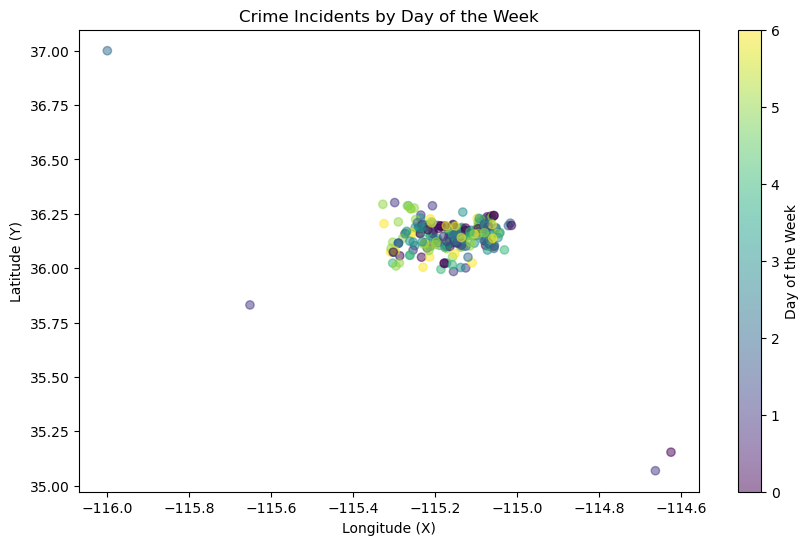

In [55]:
import matplotlib.pyplot as plt
import numpy as np

 #1: Plotting the crime incidents as a scatter plot using coordinates, color by day of the week

plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()




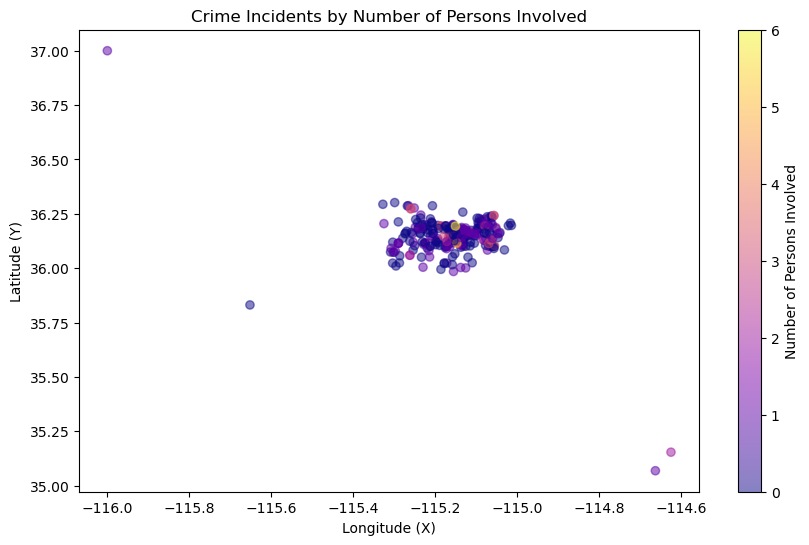

In [56]:
# 2: Creating a scatter plot, color by the number of persons involved in the incident

plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='plasma', alpha=0.5)
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()



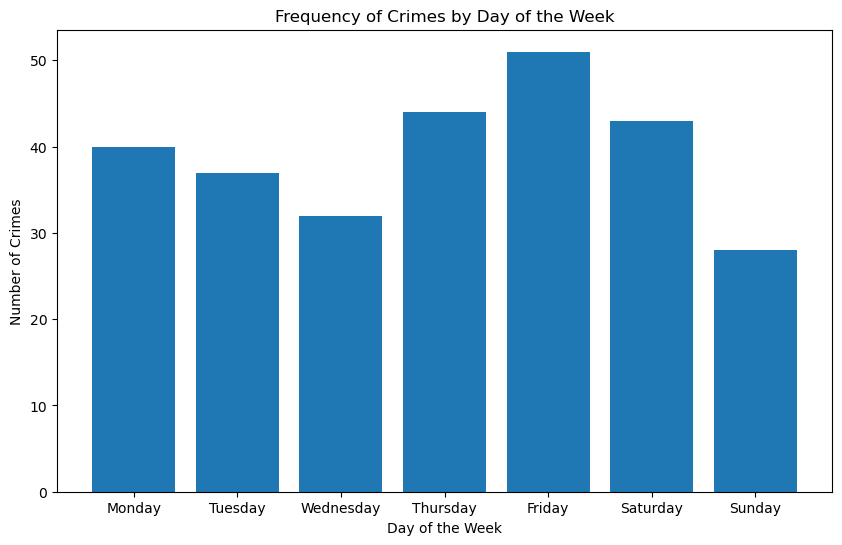

The most frequent day for crimes is Friday.


In [57]:
#3: Sorting  the number of crimes reported by the day of the week and find the most frequent day

day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(days, day_of_week_counts)
plt.title('Frequency of Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

most_frequent_day = days[np.argmax(day_of_week_counts)]
print(f"The most frequent day for crimes is {most_frequent_day}.")